In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

In [2]:
today = date.today()
#5 year
d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=365*7)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

#SPLV #appl is really good, meta, MSFT
stock= 'SPLV'

df = yf.download(stock, 
                      start=start_date, 
                      end=end_date, 
                      progress=False)
df["Date"] = df.index
df = df[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
df.reset_index(drop=True, inplace=True)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1754,2024-07-18,67.239998,67.879997,67.129997,67.169998,67.067215,900500
1755,2024-07-19,67.260002,67.410004,66.589996,66.660004,66.558006,1688100
1756,2024-07-22,66.720001,67.000000,66.540001,66.980003,66.980003,884000
1757,2024-07-23,66.980003,67.040001,66.599998,66.639999,66.639999,1015300
1758,2024-07-24,66.500000,66.690002,66.220001,66.459999,66.459999,1103900


In [3]:
df_close = df[['Date', 'Close']]

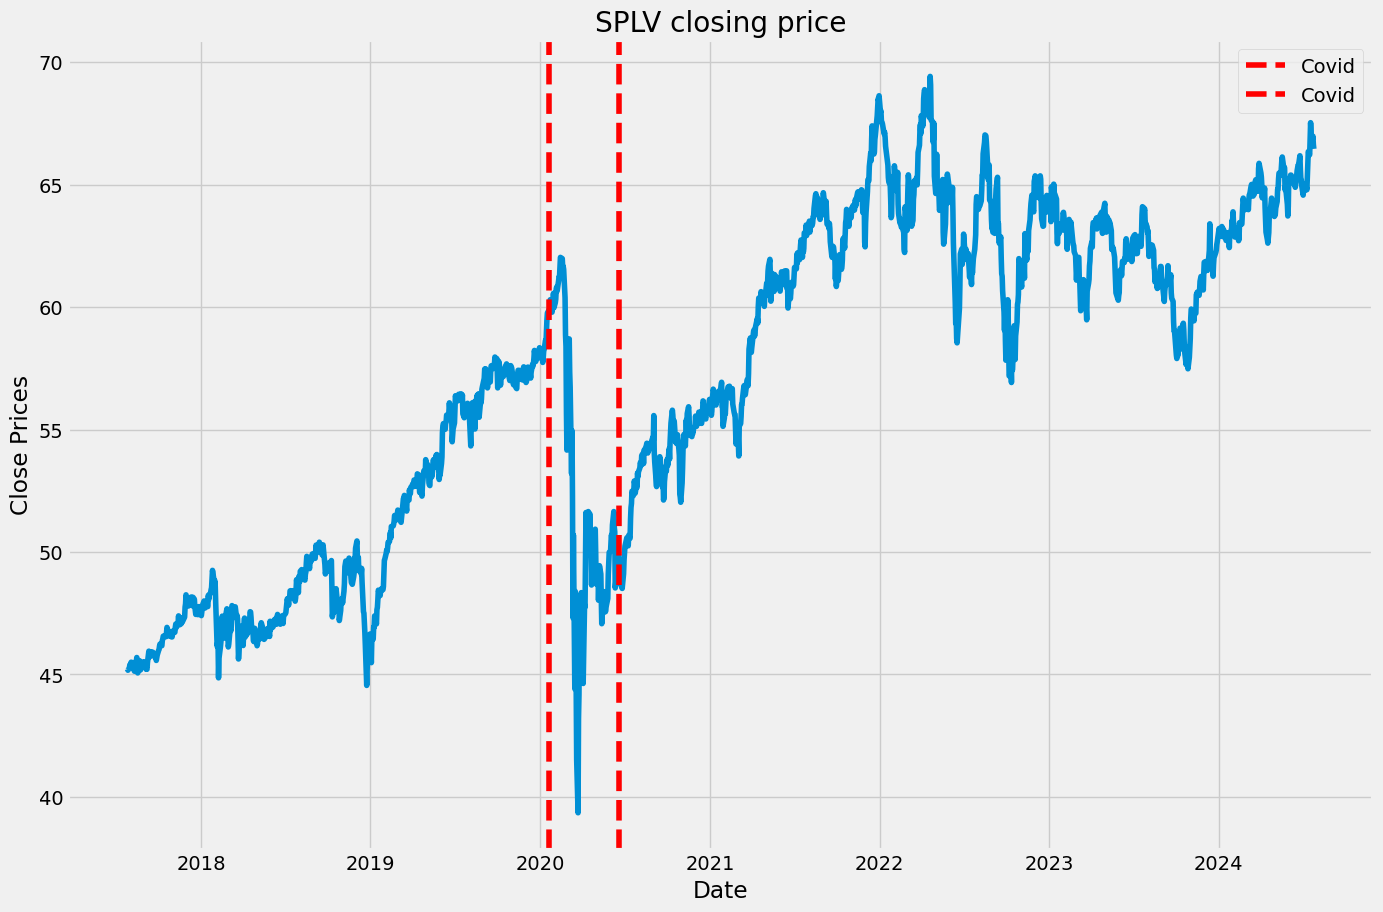

In [4]:
plt.figure(figsize=(15, 10))
plt.plot(df["Date"], df["Close"])

plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.title('{} closing price'.format(stock))

covid = ["2020-01-20","2020-06-20"]
covid = pd.to_datetime(covid)

for i in covid:
    plt.axvline(x=i, color='r', linestyle='--', label='Covid')
plt.legend()

plt.show()

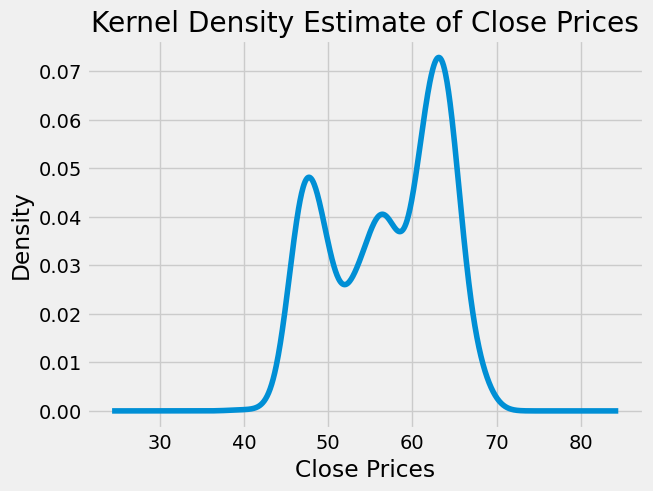

In [5]:
df_close = df[['Date', 'Close']]

# Set 'Date' column as index
df_close.set_index("Date", inplace=True)

# Plot KDE for the numerical 'Close' column
df_close["Close"].plot(kind='kde')

plt.xlabel('Close Prices')
plt.title('Kernel Density Estimate of Close Prices')
plt.show()

In [6]:
#Check data
print(df_close.head())

                Close
Date                 
2017-07-27  45.220001
2017-07-28  45.169998
2017-07-31  45.259998
2017-08-01  45.380001
2017-08-02  45.380001


ADF (Augmented Dickey-Fuller) Test

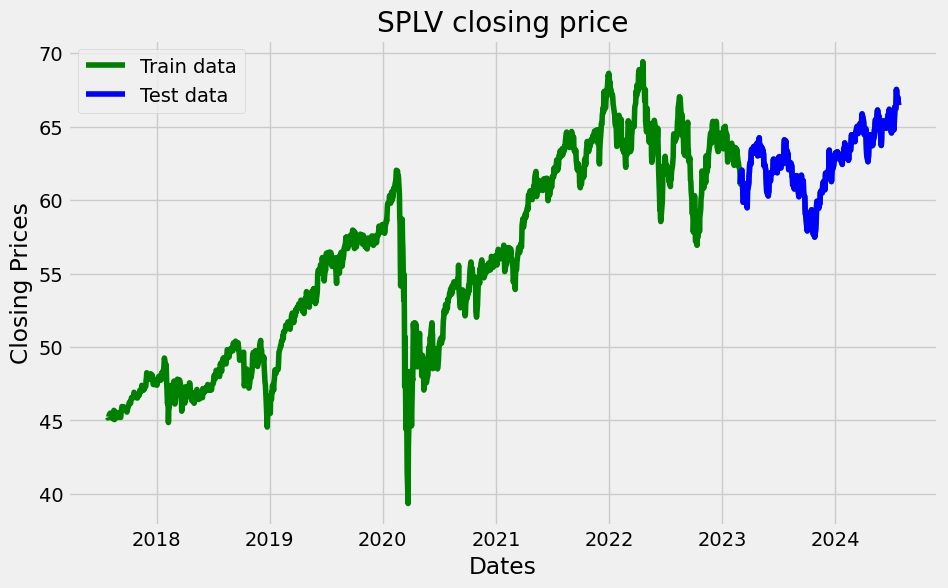

In [7]:
train_data, test_data = df_close[3:int(len(df_close)*0.8)], df_close[int(len(df_close)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_close, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.title('{} closing price'.format(stock))
plt.legend()

Since the p-value is still significantly greater than 0.05, the null hypothesis of non-stationarity cannot be rejected. This suggests that a single differencing was not sufficient to make the series stationary.

<Figure size 640x480 with 0 Axes>

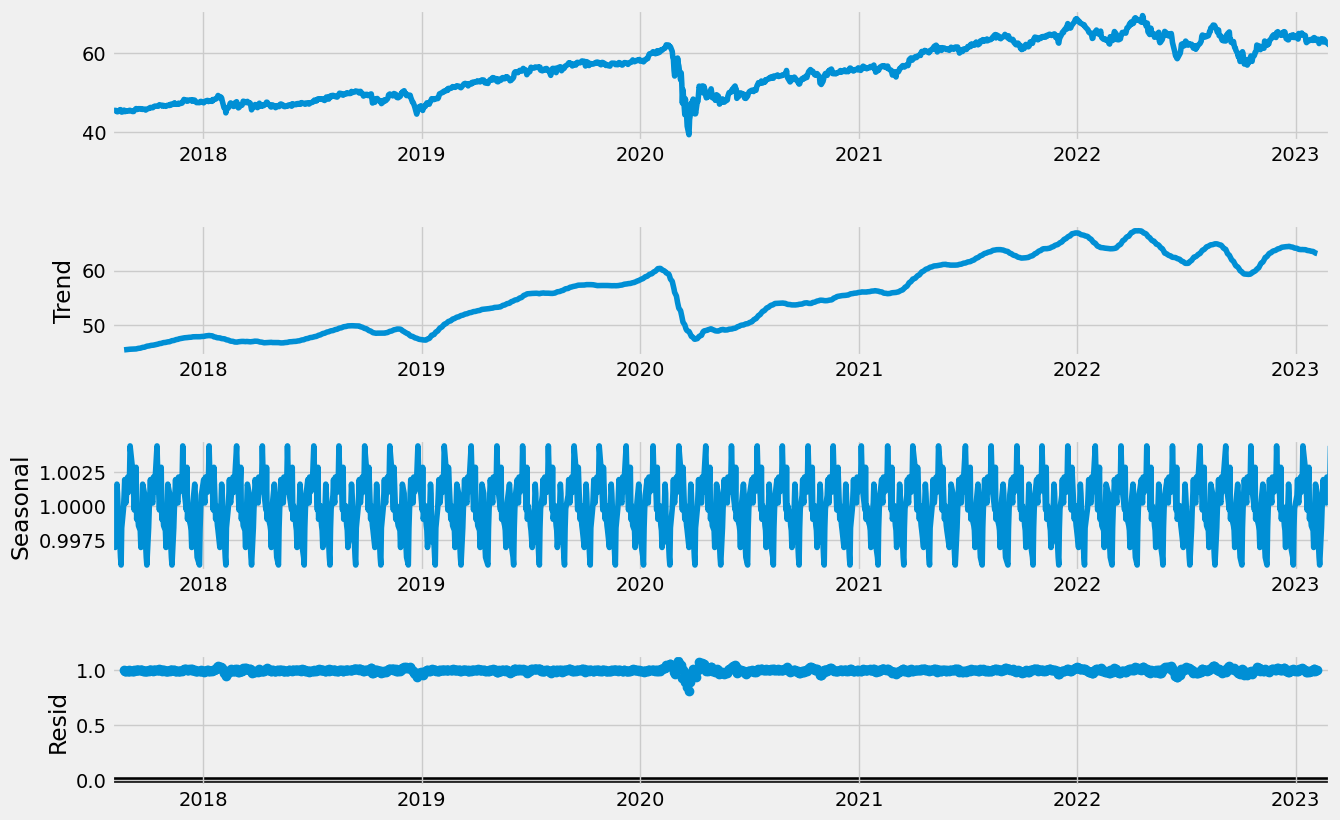

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_data, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

In [9]:
#Log data to remove seasonality
train_data_log = np.log(train_data)

In [10]:
train_data_adf = adfuller(train_data_log)
print('ADF Statistic (Differenced Series):', train_data_adf[0])
print('p-value (Differenced Series):', train_data_adf[1])

ADF Statistic (Differenced Series): -1.9583917703176617
p-value (Differenced Series): 0.3051093899856041


It's not good enough, it's still not sstationary because p value is larger than 0.05, we failed to reject the null hypothesis meaning there isn't enoguh evidence to say that this series is stationary

So we apply differencing

Still not good enough we need to apply differencing

In [11]:
train_data_diff = train_data_log.diff().dropna()

In [12]:
train_data_diff_adf = adfuller(train_data_diff)
print('ADF Statistic (Differenced Series):', train_data_diff_adf[0])
print('p-value (Differenced Series):', train_data_diff_adf[1])

ADF Statistic (Differenced Series): -11.217244257788213
p-value (Differenced Series): 2.0550483090332442e-20


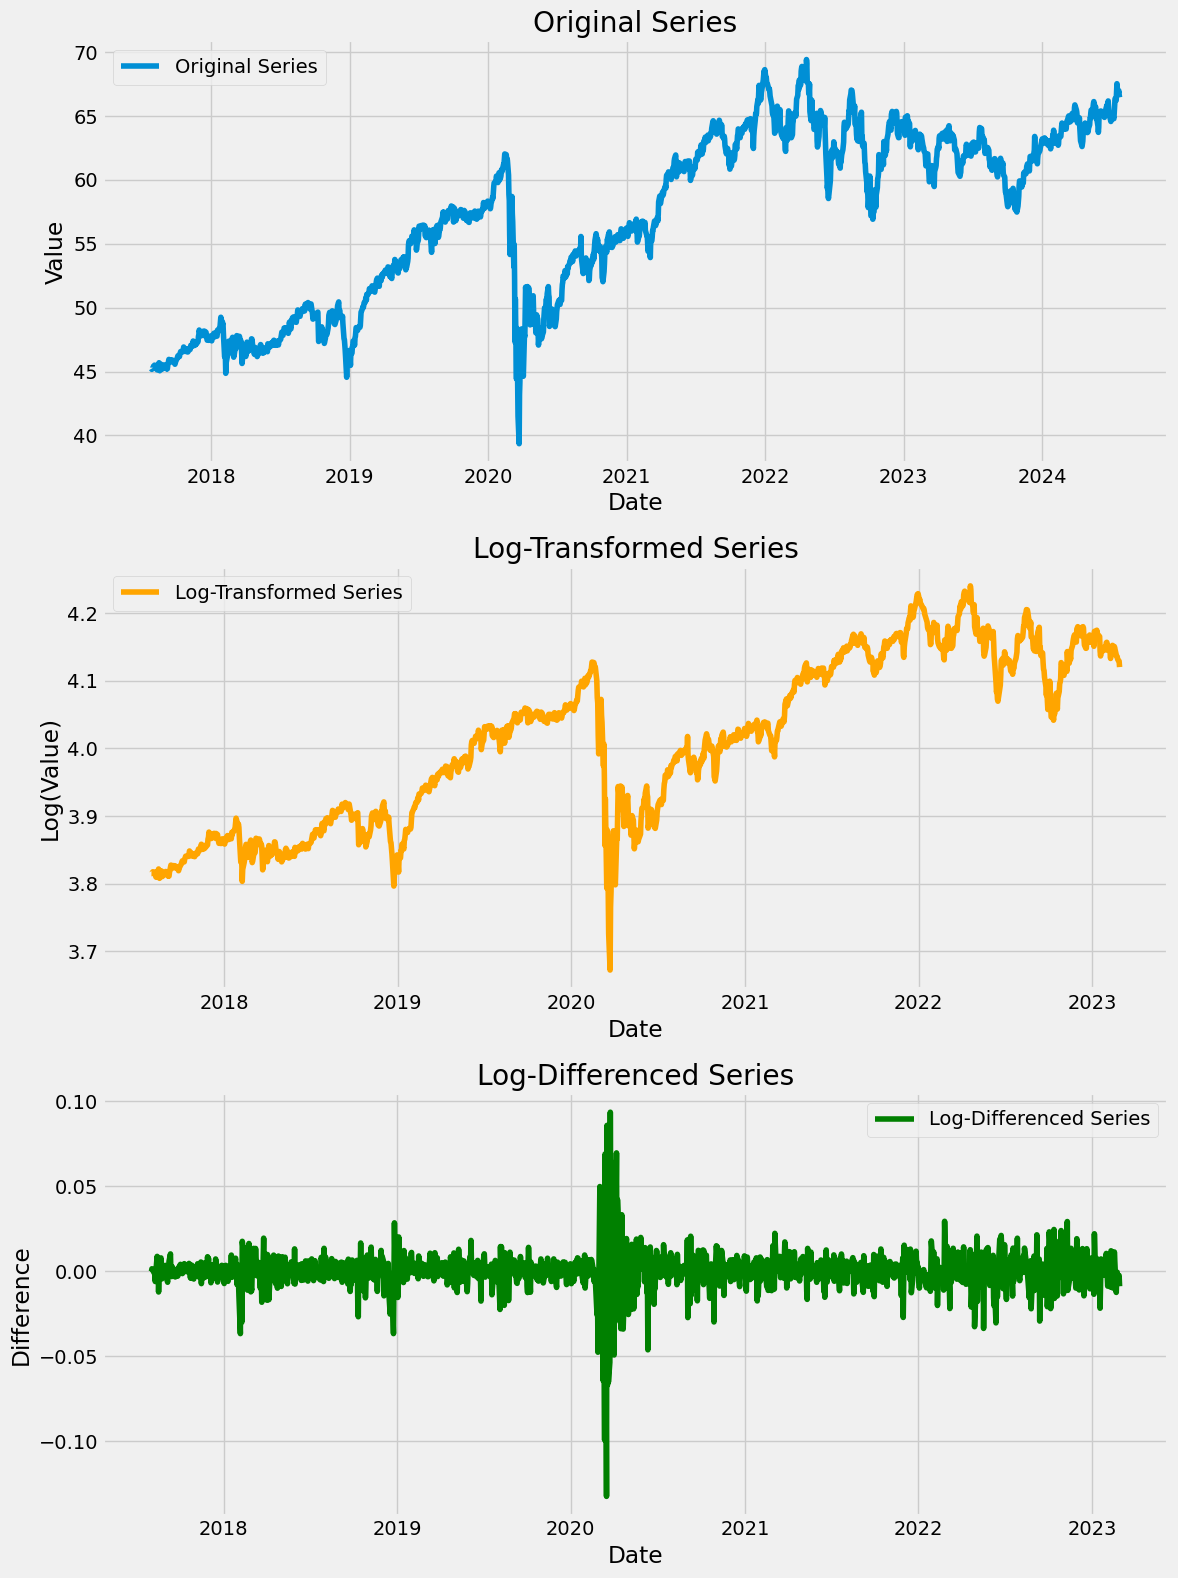

In [50]:
# Plotting
plt.figure(figsize=(12, 16))

# Original Series
plt.subplot(311)
plt.plot(df_close, label='Original Series')
plt.title('Original Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Log-Transformed Series
plt.subplot(312)
plt.plot(train_data_log, label='Log-Transformed Series', color='orange')
plt.title('Log-Transformed Series')
plt.xlabel('Date')
plt.ylabel('Log(Value)')
plt.legend()

# Differenced Series
plt.subplot(313)
plt.plot(train_data_diff, label='Log-Differenced Series', color='green')
plt.title('Log-Differenced Series')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()

plt.tight_layout()
plt.show()

next step is to split out training and testing to see how well the model performs, testing be actual data compared to our forecast

In [14]:
from pmdarima import auto_arima
model = auto_arima(train_data_diff, 
                   seasonal=False,  # Change to True if you have seasonal data
                   trace=True,
                   m=24,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True,)

p = model.order[0]
d = model.order[1]
q = model.order[2]



C:\Users\imdan\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (24) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-8594.904, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-8513.086, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-8554.861, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-8545.181, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-8584.691, Time=0.42 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-8575.349, Time=0.21 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-8683.904, Time=0.61 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-8573.605, Time=0.46 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-8596.504, Time=0.72 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-8591.202, Time=0.65 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-8683.811, Time=0.66 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-8607.935, Time=0.13 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=-8600.183, Time=0.88 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-8675.905, Time=1.27 sec

Best model:  ARIMA

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_data, 
                order=(p, d, q), 
                seasonal_order=(p, d, q, 12)) 
fitted = model.fit(disp=False) 
print(fitted.summary())

C:\Users\imdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\imdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\imdan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\imdan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 1404
Model:             SARIMAX(3, 0, 2)x(3, 0, 2, 12)   Log Likelihood               -1290.962
Date:                            Thu, 25 Jul 2024   AIC                           2603.924
Time:                                    21:51:21   BIC                           2661.642
Sample:                                         0   HQIC                          2625.497
                                           - 1404                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2186      0.024     -9.061      0.000      -0.266      -0.171
ar.L2          0.2761      0.019   

In [16]:
forecast_steps = len(test_data)  # Number of periods to forecast
total = len(train_data)
hist = total - forecast_steps

In [17]:
result = fitted.forecast(forecast_steps, alpha = 0.05)
conf_ins = fitted.get_forecast(forecast_steps).summary_frame()
ind = np.arange(total)

C:\Users\imdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\imdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [18]:
#result = np.exp(result)
#conf_ins = np.exp(conf_ins)

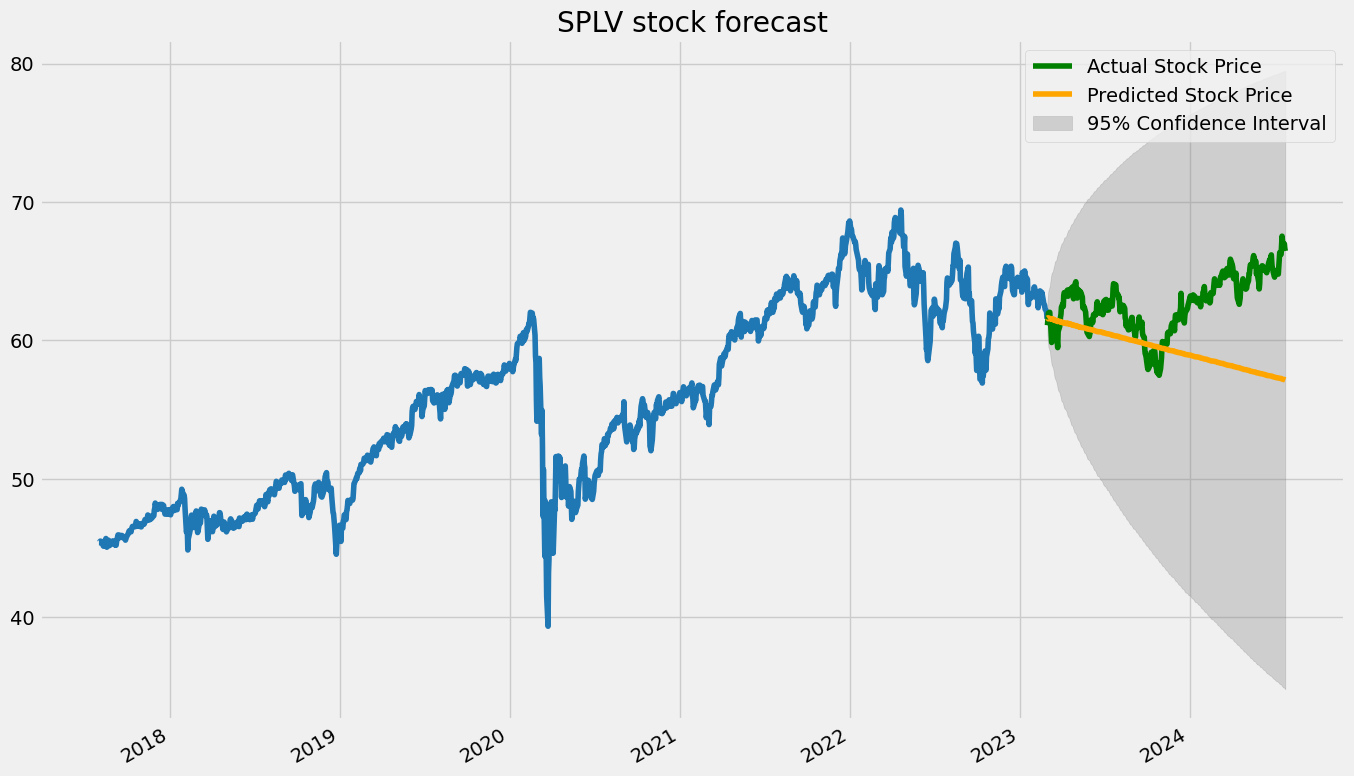

In [20]:
fig, ax = plt.subplots(figsize=(15, 10))


ax.plot(train_data.index, train_data.values, color = '#1f77b4')
ax.plot(test_data.index, test_data.values, label='Actual Stock Price',color = 'green')
ax.plot(test_data.index, result, label='Predicted Stock Price', color = 'orange')
ax.fill_between(test_data.index,conf_ins['mean_ci_lower'],conf_ins['mean_ci_upper'],color='grey', alpha=0.3,label='95% Confidence Interval')
plt.title('{} stock forecast'.format(stock))
ax.legend()
fig.autofmt_xdate()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(test_data, result)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, result)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, result))
print('RMSE: '+str(rmse))

test_series = (test_data['Close'].values)
test=result-test_series
test_data_abs = np.abs(test_data).values

mape = np.mean(np.abs(test).values)/test_data_abs
mape = np.mean(mape)
print('MAPE: '+str(mape))

SARIMA_results = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'RMSE', 'MAPE'],
    'Value': [mse, mae, rmse, mape]
})

In [ ]:
SARIMA_results

# Facebook Prophet

In [ ]:
train_data = train_data.reset_index()
train_data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

In [ ]:
train_data

In [ ]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np

def train_prophet_model(train_data, changepoint_prior_scale=0.05, seasonality_prior_scale=10, holidays_prior_scale=10,seasonality_mode='additive'):
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        seasonality_mode=seasonality_mode
    )
    model.fit(train_data)
    return model

In [ ]:
def evaluate_model(train_df, model):
    df_cv = cross_validation(model, initial='365 days', period='180 days', horizon='30 days')
    df_p = performance_metrics(df_cv)
    return df_p

In [ ]:
from itertools import product

changepoint_prior_scales = [0.01, 0.05, 0.1]
seasonality_prior_scales = [1, 10, 100]
holidays_prior_scales = [1, 10, 100]
seasonality_modes = ['additive', 'multiplicative']

results = []

for cps, sps, hps, sm in product(changepoint_prior_scales, seasonality_prior_scales, holidays_prior_scales, seasonality_modes):
    model = train_prophet_model(train_data, changepoint_prior_scale=cps, seasonality_prior_scale=sps, holidays_prior_scale=hps, seasonality_mode=sm)
    metrics = evaluate_model(train_data, model)
    metrics['changepoint_prior_scale'] = cps
    metrics['seasonality_prior_scale'] = sps
    metrics['holidays_prior_scale'] = hps
    metrics['seasonality_mode'] = sm
    results.append(metrics)

results_df = pd.concat(results, ignore_index=True)

In [ ]:
best_model_params = results_df.loc[results_df['rmse'].idxmin()]

In [ ]:
best_params = {
    'changepoint_prior_scale': best_model_params['changepoint_prior_scale'],
    'seasonality_prior_scale': best_model_params['seasonality_prior_scale'],
    'holidays_prior_scale': best_model_params['holidays_prior_scale'],
    'seasonality_mode': best_model_params['seasonality_mode']
}

final_model = train_prophet_model(train_data, **best_params)

In [ ]:
test_data = test_data.reset_index()
test_data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

In [ ]:
test_forecast = final_model.predict(test_data)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

test_y = test_data['y']  # Actual values
predicted_y = test_forecast['yhat']  # Predicted values

mse = mean_squared_error(test_y, predicted_y)
mae = mean_absolute_error(test_y, predicted_y)
rmse = math.sqrt(mse)
mape = np.mean(np.abs(test_y - predicted_y) / np.abs(test_y))

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

PROPHET_results = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'RMSE', 'MAPE'],
    'Value': [mse, mae, rmse, mape]
})

In [ ]:
best_model_params

In [ ]:
best_params = {
    'changepoint_prior_scale': best_model_params[8],
    'seasonality_prior_scale': best_model_params[9],
    'holidays_prior_scale': best_model_params[10],
    'seasonality_mode': best_model_params[11]
}

In [ ]:
model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    seasonality_mode=best_params['seasonality_mode']
)
model.fit(train_data)

In [ ]:
future = model.make_future_dataframe(periods=len(train_data),freq='D') 

# Predict future values
forecast = model.predict(future)

In [ ]:
forecast

In [ ]:
test_data

In [ ]:
matched_data = test_data.merge(forecast, on='ds', how='left')

In [ ]:
matched_data 

In [ ]:
# Plot the results
fig = plt.figure(figsize=(14, 7))

# Plot the original data
plt.plot(train_data['ds'], train_data['y'], label='Training Data', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Test Data', color='green')

# Plot the forecasted data
plt.plot(matched_data ['ds'], matched_data ['yhat'], label='Forecast', color='orange')

# Plot the confidence intervals
plt.fill_between(matched_data ['ds'], matched_data ['yhat_lower'], matched_data ['yhat_upper'], color='gray', alpha=0.2)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('{} Stock Price Forecast with Best Parameters'.format(stock))
plt.legend()
plt.ylim(0,80)

plt.show()

In [ ]:
# Plot the results
fig = plt.figure(figsize=(14, 7))

# Plot the original data
plt.plot(train_data['ds'], train_data['y'], label='Training Data', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Test Data', color='green')

# Plot the forecasted data
plt.plot(forecast['ds'], forecast ['yhat'], label='Forecast', color='orange')

# Plot the confidence intervals
plt.fill_between(forecast ['ds'], forecast ['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('{} Stock Price Forecast with Best Parameters'.format(stock))
plt.legend()
#plt.ylim(0,400)

plt.show()

In [ ]:
fig = model.plot_components(forecast)

plt.show()

In [ ]:
PROPHET_results

In [ ]:
test_y = test_data['y']  # Actual values
predicted_y = matched_data ['yhat']  # Predicted values

mse = mean_squared_error(test_y, predicted_y)
mae = mean_absolute_error(test_y, predicted_y)
rmse = math.sqrt(mse)
mape = np.mean(np.abs(test_y - predicted_y) / np.abs(test_y))

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

PROPHET_results = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'RMSE', 'MAPE'],
    'Value': [mse, mae, rmse, mape]
})